**Import Modules**


In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import numpy as np
sys.path.append(os.chdir("../"))
from HALSS_utils.halss_utils import halss_data_packet, flags_required, parameters, coarse_landing_region_selection, multithread_fine_site_selection
from HALSS_utils.plotting_utils import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


**Initialize Parameters, Flags, and HALSS Datapacket**

In [2]:
# #####################
# Flags
# #####################
flags = flags_required()
flags.flag_plot_origin = False
flags.flag_plot_circles = False # Only relevant for Airsim simulation
flags.flag_show_images = False
flags.flag_save_images = False
flags.flag_timing = False
flags.flag_offset = False
flags.flag_debug = False
flags.flag_coarse_method = 'geo' # Choose "geo" for inclination-based HD or "nn" for learning-based HD

# #####################
# Initialize Parameters
# #####################
params = parameters()
params.x_cell_size_coarse = 4 # Size of cell in x direction for Coarse Downsampling
params.y_cell_size_coarse = 4 # Size of cell in y direction for Coarse Downsampling
params.x_cell_size_fine = 0.5 # Size of cell in x direction for Fine Downsampling
params.y_cell_size_fine = 0.5 # Size of cell in y direction for Fine Downsampling
params.alpha = 8 # Maximum allowable inclination angle in degrees
params.max_sites = 6 # Maximum number of sites to be considered
params.grid_res = 320 # Resolution of grid to be used for segmentation
params.thresh = 0.1 # Threshold for variance-aware safety map threshold
params.num_mc_samples = 30 # Number of Monte Carlo samples to be used for variance-aware safety map
params.media_save_path = os. getcwd() + '\\figures\\HALSS\\' # Path to save images

# #####################
# Initialize HALSS Datapacket
# #####################
halss_global = halss_data_packet()
halss_global.num_circles = params.max_sites

halss_global.x_cell_size = params.x_cell_size_coarse # Size of cell in x direction for Coarse Downsampling
halss_global.y_cell_size = params.y_cell_size_coarse # Size of cell in y direction for Coarse Downsampling


**Import Demo Pointcloud**


In [3]:
halss_global.pcd_full = np.load(os. getcwd() + '\\HALSS\\demo_pointcloud.npy')
halss_global.pcd_new = halss_global.pcd_full

pcd_combined = o3d.geometry.PointCloud()
pcd_combined.points = o3d.utility.Vector3dVector(halss_global.pcd_full)
#o3d.visualization.draw_plotly([pcd_combined], point_sample_factor=0.2) # Draws in Notebook but looks bad
#o3d.visualization.draw_geometries([pcd_combined]) # Draws in separate window but looks good

**Convert Pointcloud to Surface Normal**

To create the surface normal, a we linearly interpolate a function to fit the pointcloud. We then sample the function at equal grid spacings. The gradient of the surface is then found and used to create the unit normal vector $\hat{u} = \frac{\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}} {\left|\left|\begin{bmatrix} -\delta x & -\delta y & 1 \end{bmatrix}\right|\right|}$. This vector, $\hat{u}$, is represented by the $r$, $g$, and $b$ values which is unit normal vector to the surface at that point.

In [4]:
halss_global.pcd_culled_dict = {}
halss_global.downsample_pointcloud_dict()
halss_global.downsample_pointcloud() # Downsample point cloud data

**Coarse Hazard Detection**

--> [HALSS: Using  NVIDIA GeForce RTX 3090  for learning based Coarse HD]
c:\Users\chris\Documents\HALO


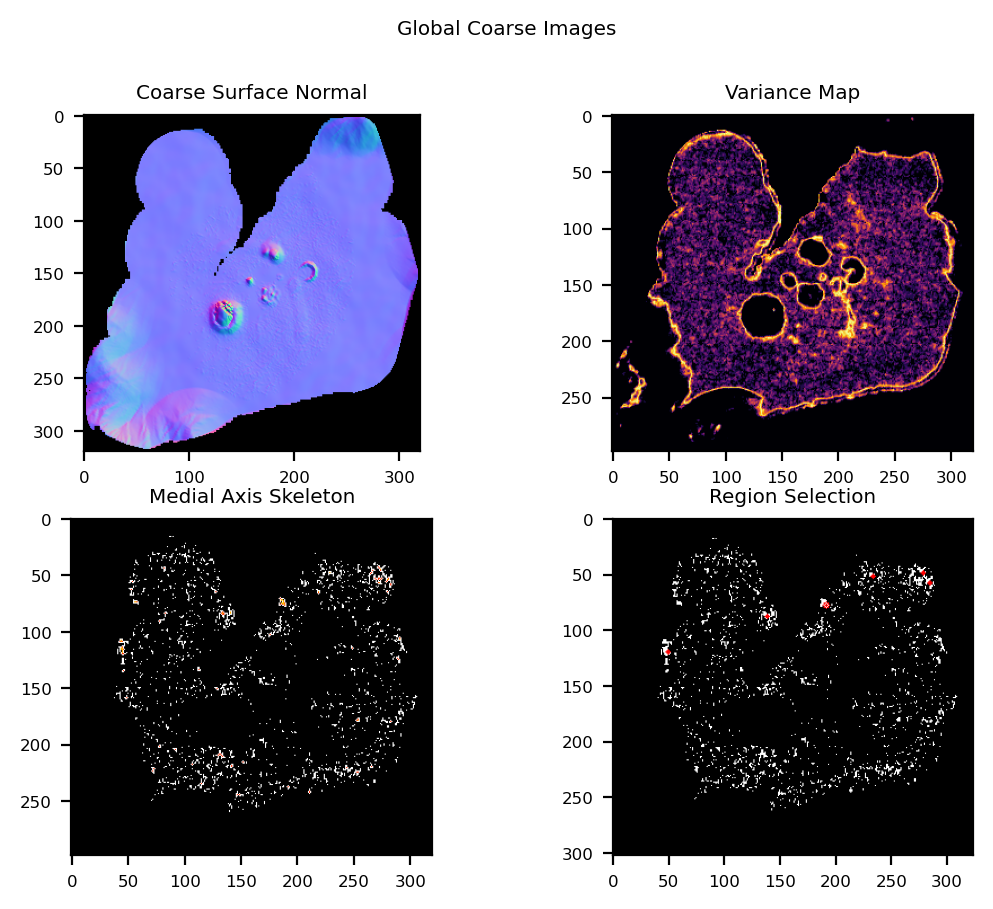

In [5]:
halss_global = coarse_landing_region_selection(halss_global, flags, params)
plot_coarse_images(halss_global)

**Fine Landing Hazard Detection**

In [6]:
halss_global = multithread_fine_site_selection(halss_global, flags, params)

In [7]:
# #####################
# Find UV to World NED Scale Factor
# #####################
min_new_x = 0
max_new_x = png_scaled.shape[1]
min_new_y = 0
max_new_y = png_scaled.shape[0]

sf_x, sf_y = scale_uv_2_world(pcd, min_new_x, min_new_y, max_new_x, max_new_y)

# #####################
# Find NED Origin in UV Pixel Space
# #####################
x_pcd_to_surface = min_new_x - (max_new_x-min_new_x)/(pcd[:,0].max()- pcd[:,0].min()) * (pcd[:,0].min())
y_pcd_to_surface = min_new_y + (max_new_y-min_new_y) * (0 - pcd[:,1].min())/(pcd[:,1].max() - pcd[:,1].min())

org_x = x_pcd_to_surface
org_y = max_new_y - y_pcd_to_surface

NameError: name 'png_scaled' is not defined

In [ ]:
plt.imshow(png_scaled[:,:,[2,1,0]], extent = [0, sf_x*png_scaled.shape[0], 0, sf_x*png_scaled.shape[1]])
plt.suptitle('Surface Normal')
plt.show()

**Run Segmentation Network**

Run the surface normal through the segmentation network. Monte Carlo Dropout is used to approximate the Bayesian Uncertainty in the Network. The network architecture is based on Segnet with Dropout after each encoder and decoder unit. The output safety map is the mean of the MC samples and the variance map is the vairance of the MC samples. Unobserved reigons of the terrain are considered unsafe.

In [ ]:
safety_map, var_scaled, norm_resized_var = run_network(normalize(png.transpose(2,0,1)), net, device, pcd, 50)
plt.imshow(safety_map, extent = [0, sf_x*safety_map.shape[0], 0, sf_x*safety_map.shape[1]])
plt.suptitle('Mean of MC Samples (0 = Unsafe, 1 = Safe)')
plt.show()

In [ ]:
plt.imshow(norm_resized_var, cmap = 'gray', extent = [0, sf_x*norm_resized_var.shape[0], 0, sf_x*norm_resized_var.shape[1]])
plt.suptitle('Variance of MC Samples (0 = Low Variance, 1 = High Variance)')

In [ ]:
var_thresh = 0.9
thresh_safety = var_aware_safety_map(safety_map, norm_resized_var, var_thresh)
plt.imshow(thresh_safety, extent = [0, sf_x*thresh_safety.shape[0], 0, sf_x*thresh_safety.shape[1]])
plt.suptitle('Variance Aware Safety Map with Threshold of %i'%(var_thresh*100) + '%')
plt.show()

In [ ]:
diff = safety_map - thresh_safety
plt.imshow(diff, extent = [0, sf_x*diff.shape[0], 0, sf_x*diff.shape[1]])
plt.suptitle('Difference between Variance Aware Safety Map and Mean of MC Samples')
plt.title('(0 = No Difference, 1 = Difference)')
plt.show()

**Determine Safe Landing Sites**

The Medial Axis Skeleton is used to determine the location of the top $N$ largest inscribed circles within the safe reigon (white pixels) of the Safety Map (Mean of MC Samples) with the constraint that the center of one circle cannot lie within any other circle. The color value of the skeleton corresponds to how far away the nearest unsafe reigon is from that point on the skeleton.

In [ ]:
num_circles = 10
radii, center_coords, skel, circles, dist = landingselection(thresh_safety.astype(np.uint8), num_circles)
plt.imshow(skel, cmap='hot', extent = [0, sf_x*skel.shape[0], 0, sf_y*skel.shape[1]], origin='upper')
plt.contour(thresh_safety[:,:,0], [0,1], colors='w', linewidths=1, extent = [0, sf_x*thresh_safety.shape[0], 0, sf_y*thresh_safety.shape[1]], origin='upper')
plt.suptitle('Medial Axis Transform (MAT) Skeleton')
plt.show()

In [ ]:
num_levels = 7
contours = plt.contour(sf_x*dist, num_levels, colors = 'white', origin = 'upper', extent = [0, sf_x*dist.shape[0], 0, sf_y*dist.shape[1]])
plt.clabel(contours, inline = True, fontsize = 8, colors = 'white')
plt.contourf(sf_x*dist, num_levels, cmap = 'hot', extend = 'both', origin = 'upper', extent = [0, sf_x*dist.shape[0], 0, sf_y*dist.shape[1]])
plt.colorbar()
plt.suptitle('Distance Contours from Unsafe Regions')
plt.title('From MAT')
plt.show()


In [ ]:
plt.imshow(circles)
plt.suptitle('Top %i Largest Circles' %num_circles)
plt.show()

In [ ]:
# #####################
# Score Landing Sites
# #####################
max_sites = 7
center_coords_ned = np.zeros((len(radii), 3))
for idx, center in enumerate(center_coords):
    center_coords_ned[idx] = (uv2WorldNED(pcd, center_coords[idx][0][0], center_coords[idx][1][0], min_new_x, min_new_y, max_new_x, max_new_y, org_x, org_y))

scores = score_landings(center_coords[0:max_sites], 
                        center_coords_ned[0:max_sites], 
                        radii[0:max_sites], 
                        safety_map, 
                        var_scaled, 
                        pcd,
                        min_new_x, 
                        min_new_y, 
                        max_new_x, 
                        max_new_y)
print(scores.T)